# Analysis of Rosbank's customer reviews [banki.ru](https://www.banki.ru)
Featured products
* *debitcards*
* *creditcards*
* *hypothec* - mortgage loans
* *credits* - consumer credits
* *deposits*

For complains/thanks classification webpage's own division is used
* "о хорошем" (good) - ratings 1-2
* "о плохом" (bad) - ratings 4-5

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
# import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

In C:\Program Files\Python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Program Files\Python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Program Files\Python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Program Files\Python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Program Files\Python38\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
def parse_product(bank='rosbank',
                  product='debitcards',
                  rated=True) -> pd.DataFrame:
    """
    Returns all customer reviews from banki.ru for the given bank and product.
    
    
    Parameters
    ----------
    bank : str, default: 'rosbank'
        Bank name from banki.ru. Look it up in the address bar while browsing.

    product : str, default: 'debitcards'
        Name of the product to parse reviews of. Again, must be from
        banki.ru.

    rated : bool, default: True
        Whether to accept only rated or unrated reviews.


    Returns
    -------
    pandas.DataFrame
        DataFrame with reviews according to the parameters.
    """
    # initializing final lists and some parameters for the query
    page = 1
    rated = 'rate[]=1&rate[]=2&rate[]=3&rate[]=4&rate[]=5&' if rated else ''
    Review = []
    if rated:
        Rating = []

    # starting to parse
    while True:
        url = f'https://www.banki.ru/services/responses/bank/{bank}/product/{product}/?{rated}page={page}&isMobile=0'
        req = requests.get(url)
        if req.status_code == 200:
            tree = BeautifulSoup(req.content,
                                 'html.parser')
            headers = tree.find_all('a',
                                    'header-h3')
            bodies = tree.find_all('div',
                                   'responses__item__message markup-inside-small markup-inside-small--bullet')

            # prettifying reviews
            reviews = [header.text + '\n' + body.get_text('\n').strip().replace('\xa0', ' ')
                       for header, body in zip(headers, bodies)]
            if rated:
                ratings = tree.find_all('span',
                                        {'data-test': 'responses-rating-grade'})
                Rating.extend([int(rating.text.strip()) for rating in ratings])
            Review.extend(reviews)

            # moving on to the next webpage
            page += 1

        # request throws 404 when we run out of pages
        elif rated:
            return pd.DataFrame({'Review': Review,
                                 'Rating': Rating,
                                 'Product': product})
        else:
            return pd.DataFrame({'Review': Review,
                                 'Product': product})

In [3]:
# preparing categories of products to extract
products = ['debitcards',
            'creditcards',
            'hypothec',
            'credits',
            'deposits']

In [4]:
# parsing
df = pd.concat((parse_product(product=product) for product in products),
               ignore_index=True)

In [5]:
# creating target column for complains/thanks
df['IsGratitude'] = (df.Rating > 3).astype(int)

# creating target column for product classification
encoder = LabelEncoder()
encoder.fit(df.Product)
df['Product_int'] = encoder.transform(df.Product)

# product -> class
products_to_int = sorted(zip(products, encoder.transform(products)),
                         key=lambda x: x[-1])

### Optional: saving the gathered data

In [6]:
from datetime import date


bank = 'rosbank'
df.to_csv(bank + '_reviews_' + str(date.today()) + '.csv')

## Binary classification into complains/thanks
**This is true for Rosbank data and has not been tested on others!**

Classes are unbalanced, but still choosing accuracy as metric.


Even with Cost-Complexity Pruning and regularization the ceiling for test accuracy seems to be
- 95% Random Forest
- 95% Gradient Boosting
- 96.4% Lasso Regression (l1)
- 97.3% Ridge Regression (l2)


- 97.5% Complement Naive Bayes with alpha=0.0302
- 97.9% SVC with sigmoid kernel and C=1.9

**Linear SVC with hinge loss and C=4 scores ~98.3%**

***As of 22.08.2020:***
- 97.5% ComplementNB with aplha=0.1
- 97.6% Linear SVC with hinge loss and C=4
- 97.7% SVC with sigmoid kernel and C=1.9

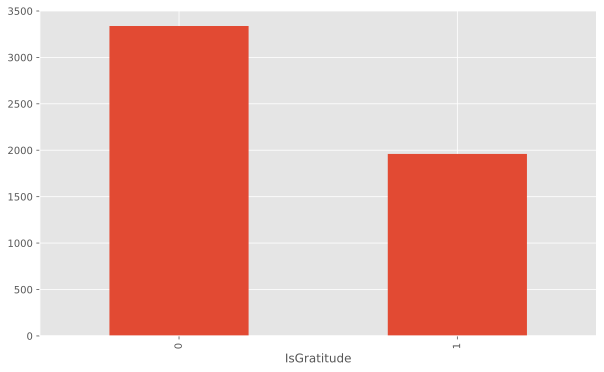

In [7]:
# observing classes
fig = plt.figure(figsize=(10, 6))
df.groupby('IsGratitude').Review.count().plot.bar(ylim=0)
plt.show()

In [8]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df[df.Rating != 3].Review.values,
                                                    df[df.Rating != 3].IsGratitude.values,
                                                    test_size=0.2,
                                                    random_state=173)

# preprocessing
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [9]:
# training the model
lsvc = LinearSVC(C=2,
                 loss='hinge',
                 random_state=173)
lsvc.fit(X_train_vect, y_train)

# observing test score
lsvc.score(X_test_vect, y_test)

0.9794921875

In [10]:
# training the model
svc = SVC(C=1.9,
          kernel='sigmoid',
          random_state=173)
svc.fit(X_train_vect, y_train)

# observing test score
svc.score(X_test_vect, y_test)

0.9765625

In [11]:
# training the model
cnb = ComplementNB(alpha=0.1)
cnb.fit(X_train_vect, y_train)

# observing test score
cnb.score(X_test_vect, y_test)

0.9697265625

## Multinomial classification into different products

Classes are unbalanced, still using accuracy with some hope.
- 49.4% Multinomial Naive Bayes with C=1e-100
- 57.4% Multi-layer Perceptron classifier
- 62.7% Random Forest
- 63.3% Ridge Regression (l2) with C=0.95

**65.9% Linear SVC with C=0.6**

***As of 22.08.2020:***
- 64.2% Linear SVC with C=0.3 or 0.4

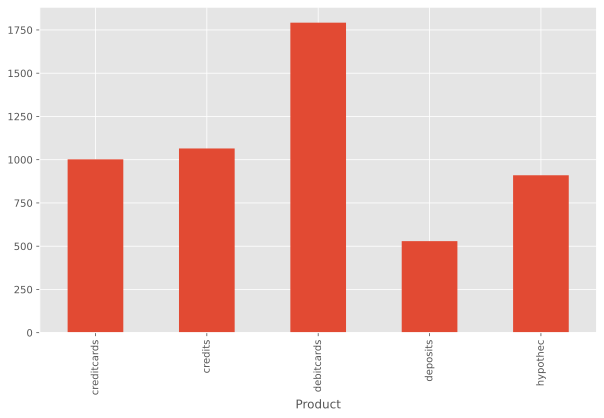

In [12]:
# observing classes
fig = plt.figure(figsize=(10, 6))
df.groupby('Product').Review.count().plot.bar(ylim=0)
plt.show()

In [13]:
# hoping that stop words will improve the quality
stop_w_ru_nltk = stopwords.words("russian")

In [14]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df.Review.values,
                                                    df.Product_int.values,
                                                    test_size=0.2,
                                                    random_state=173)

# preprocessing
# NOTE: for previous classification these parameters do not really change accuracy
vectorizer = TfidfVectorizer(min_df=5,
                             ngram_range=(1, 2),
                             stop_words=stop_w_ru_nltk,
                             sublinear_tf=True)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [15]:
# training the model and observing reports
lsvc = LinearSVC(C=0.3,
                 loss='hinge',
                 random_state=173)
lsvc.fit(X_train_vect, y_train)
print(
    'training report:',
    classification_report(y_train,
                          lsvc.predict(X_train_vect),
                          target_names=df.Product.unique()),
    '=' * 80,
    'test report:',
    classification_report(y_test,
                          lsvc.predict(X_test_vect),
                          target_names=df.Product.unique()),
    sep='\n'
)

training report:
              precision    recall  f1-score   support

  debitcards       0.85      0.62      0.71       804
 creditcards       0.85      0.88      0.86       846
    hypothec       0.75      0.93      0.83      1433
     credits       0.88      0.59      0.71       420
    deposits       0.92      0.91      0.92       735

    accuracy                           0.82      4238
   macro avg       0.85      0.78      0.81      4238
weighted avg       0.83      0.82      0.82      4238

test report:
              precision    recall  f1-score   support

  debitcards       0.59      0.40      0.48       198
 creditcards       0.62      0.53      0.57       219
    hypothec       0.61      0.84      0.71       359
     credits       0.68      0.39      0.49       109
    deposits       0.76      0.79      0.78       175

    accuracy                           0.64      1060
   macro avg       0.65      0.59      0.60      1060
weighted avg       0.64      0.64      0.63    

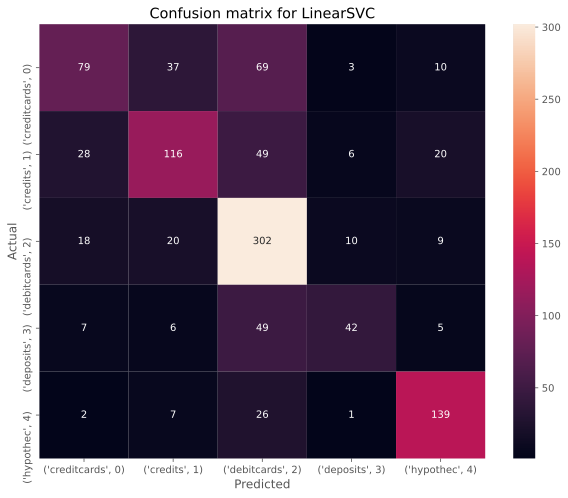

In [16]:
# looking for mistakes in classification
fig = plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, lsvc.predict(X_test_vect)),
            annot=True,
            fmt='d',
            xticklabels=products_to_int,
            yticklabels=products_to_int)
plt.title('Confusion matrix for LinearSVC')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Most of the test code which helped to determine the best classifier for the data. Some of the methods are just brute force; more or less exhaustive search.

In [ ]:
# import numpy as np

# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble.forest import RandomForestClassifier
# from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
# from sklearn.naive_bayes import ComplementNB, MultinomialNB
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier

In [ ]:
# cv = KFold(shuffle=True, random_state=173)

# dec_tree = DecisionTreeClassifier(random_state=173)
# ccp_alphas = dec_tree.cost_complexity_pruning_path(X_train_vect,
#                                                    y_train).ccp_alphas

# train_scores = []
# test_scores = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=173, ccp_alpha=ccp_alpha)
#     clf.fit(X_train_vect, y_train)
#     train_scores.append(clf.score(X_train_vect, y_train))
#     test_scores.append(clf.score(X_test_vect, y_test))
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train",
#         drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

In [ ]:
# svc = SVC(random_state=173)
# gb = GradientBoostingClassifier(random_state=173)
# rf = RandomForestClassifier(n_jobs=-1,
#                             random_state=173)

# # GB and RF underfit with ccp or I couldn't find the best one
# grid = {
#     'SVC': {'C': np.arange(1, 2.5, .1),
#             'kernel': ['linear', 'sigmoid']},
#     'GB': {'learning_rate': [0.75, 0.5, 0.4, 0.3, 0.15, 0.05],
#            'n_estimators': [32, 64, 128, 256]},
#     'RF': {'n_estimators': [32, 64, 128, 256]}
# }
# models = {}
# for name, model in zip(['SVC', 'GB', 'RF'], [svc, gb, rf]):
#     gs = GridSearchCV(model,
#                       grid[name],
#                       scoring='accuracy',
#                       n_jobs=-1,
#                       cv=cv)
#     gs.fit(X_train_vect, y_train)
#     models[name] = [gs.best_estimator_,
#                     gs.best_score_,
#                     accuracy_score(y_test, gs.predict(X_test_vect)),
#                     gs.cv_results_]

In [ ]:
# # also tested with l1-regularization
# # optimal C: for l1 - 8.95, for l2 - 5.7
# logreg = LogisticRegressionCV(Cs=np.arange(.05, 10.05, .05),
#                               cv=cv,
#                               penalty='l2',
#                               scoring='accuracy',
#                               solver='saga',
#                               n_jobs=-1,
#                               random_state=173)
# logreg.fit(X_train_vect, y_train)
# models['LR'] = [LogisticRegression(C=5.7,
#                                    random_state=173,
#                                    solver='saga',
#                                    n_jobs=-1),
#                 logreg.score(X_train_vect, y_train),
#                 logreg.score(X_test_vect, y_test),
#                 None]

In [ ]:
# alphas = np.arange(0.03, .04, .0001)
# accuracies = []
# for alpha in alphas:
#     cnb = ComplementNB(alpha=alpha)
#     cnb.fit(X_train_vect, y_train)
#     accuracies.append(cnb.score(X_test_vect, y_test))
# print(f'max score {max(accuracies)} with alpha={alphas[np.argmax(accuracies)]}')

In [ ]:
# svc = SVC(C=1.9,
#           kernel='sigmoid',
#           random_state=173)
# svc.fit(X_train_vect, y_train)
# print(f'test score for SVC: {svc.score(X_test_vect, y_test)}')

The same for multinomial classification, though with much less success.

In [ ]:
# Cs = np.arange(0.1, 10.1, 0.1)
# accuracy = []
# for C in Cs:
#     lsvc = LinearSVC(C=C,
#                      loss='hinge',
#                      random_state=173)
#     lsvc.fit(X_train_vect, y_train)
#     accuracy.append(lsvc.score(X_test_vect, y_test))
# max_acc = max(accuracy)
# print(max_acc, Cs[accuracy.index(max_acc)])

In [ ]:
# Cs = np.arange(0.1, 10.1, 0.1)
# accuracy = []
# for C in Cs:
#     svc = SVC(C=C,
#               kernel='sigmoid',
#               random_state=173)
#     svc.fit(X_train_vect, y_train)
#     accuracy.append(svc.score(X_test_vect, y_test))
# max_acc = max(accuracy)
# print(max_acc, accuracy.index(max_acc))

In [ ]:
# rf = RandomForestClassifier(
#     n_jobs=-1,
#     random_state=173
# )
# rf.fit(X_train_vect, y_train)
# rf.score(X_test_vect, y_test)

In [ ]:
# logreg = LogisticRegressionCV(Cs=[.05, .02, .04, .75, 1, 2, 3],
#                               cv=cv,
#                               penalty='l2',
#                               scoring='accuracy',
#                               solver='saga',
#                               n_jobs=-1,
#                               multi_class='ovr',
#                               random_state=173)
# logreg.fit(X_train_vect, y_train)

In [ ]:
# alphas = np.power(10, np.arange(-100, -2, dtype=float))
# accuracy = []
# for alpha in alphas:
#     mnb = MultinomialNB()
#     mnb.fit(X_train_vect, y_train)
#     accuracy.append(mnb.score(X_test_vect, y_test))
# print(max(accuracy), alphas[np.argmax(accuracy)])

In [ ]:
# mlp = MLPClassifier(random_state=173)
# mlp.fit(X_train_vect, y_train)
# mlp.score(X_test_vect, y_test)
# mlp.score(X_train_vect, y_train)